In [1]:
import time
import datetime
from sys import maxsize
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.linear_model import Lasso
from sklearn import preprocessing, svm
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import precision_recall_fscore_support
from IPython.display import display, HTML

# Stochastic Gradient Optimization

In [2]:
"""
Sign of learningRate determines whether to use gradient ascent/descent:
Negative learningRates = descent, positive = ascent
"""
def SGO(x, y, seed, gradientFunc, learningRate, error, maxIter):
    x = np.array(x)
    y = np.array(y)

    # Reshape 1-D arrays to column format
    # if len(x.shape) == 1:
    #     x = x.reshape(-1, 1)

    N = len(x)
    currentError = maxsize
    lastError = 0
    beta = np.array(seed)
#     print('SGO weight shape:', beta.shape)
    i = 0

    while i < maxIter:
        for i, vals in enumerate(zip(x, y)):
            xVal, yVal = vals
            gradient = gradientFunc(beta, xVal, yVal)
#         yPredicted = x.dot(beta)
#         sqErrGradient = np.array(np.dot(x.T, (yPredicted - y)) / N)
            beta += learningRate * gradient
#         currentError = np.sum(np.square(y - yPredicted)) / N
            currentError = np.sum(gradient)
#         print(currentError)

        if abs(lastError - currentError) < error:
            break
        lastError = currentError
        i += 1

    return beta

# SVM

In [12]:
class MySVM:
    def __init__(self, C, learningRate=1e-3, error=1e-2, maxIter=1000,
                 kernel='linear', method='primal'):
        if kernel == 'linear':
            self._kernelFunc =  self._linearKernel
            
        self.method = method
        self.learningRate = learningRate
        self.error = error
        self.maxIter = maxIter
        self.C = C
        self.supportVectorIndices = []
    
    def fit(self, x, y):
        xCopy = self._removeIntercept(x)
        
        if self.method == 'primal':
            seed = np.zeros(xCopy.shape[1])
            self._grad = np.ndarray(shape=seed.shape, dtype=float)
            self.weights = SGO(xCopy, y, seed, self._svmPrimalGradient,
                               -self.learningRate, self.error, self.maxIter)
            
        else:
            seed = np.zeros(len(x))
            self._grad = np.ndarray(shape=seed.shape, dtype=float)
            self._kernelLookup = self._kernelFunc(xCopy)
            self.alphas = SGO(xCopy, y, seed, self._svmDualGradient,
                    self.learningRate, self.error, self.maxIter)
            self.weights = np.sum(self.alphas * xCopy.T * y, axis=1)
            
    def predictionFunction(self, x):
        x = self._removeIntercept(x)
        return np.array([self.weights.dot(xVal) for xVal in x])
    
    def predict(self, x):
        x = self._removeIntercept(x)
        return np.sign([self.weights.dot(xVal) for xVal in x])
    
    # Return (accuracy, precision, recall, F1) tuple
    def score(self, x, yGold):
        TPs = np.ndarray(shape=(2,))
        TNs = np.ndarray(shape=(2,))
        FPs = np.ndarray(shape=(2,))
        FNs = np.ndarray(shape=(2,))
        predictions = self.predict(x)
        correct = np.sum([1 for prediction, yVal in zip(predictions, yGold)
                       if prediction == yVal])
        
        for index, classVal in enumerate([-1, 1]):
            TP = TN = FP = FN = 0
            for i, truth in enumerate(yGold):
                prediction = predictions[i]
                if prediction == truth == classVal:
                    TP += 1
                elif prediction == truth and truth != classVal:
                    TN += 1
                elif prediction != truth and truth == classVal:
                    FN += 1
                else:
                    FP += 1
            TPs[index] = TP
            TNs[index] = TN
            FPs[index] = FP
            FNs[index] = FN
        
        print('TPs:', TPs)
        print('FPs:', FPs)
        print('TNs:', TNs)
        print('FNs:', FNs)
        accuracy = np.sum(TPs / len(yGold)) / len(TPs)
        precision = np.sum(TPs / (TPs + FPs)) / len(TPs)
        recall = np.sum(TPs / (TPs + FNs)) / len(TPs)
        if precision + recall > 0:
            f1 = 2 * precision * recall / (precision + recall)
        else:
            f1 = 0
                 
        return accuracy, precision, recall, f1
    
    def _svmPrimalGradient(self, weights, x, y):
        if y * np.dot(x, weights) < 1:
            return weights - self.C * y * x - self.C * y
        else:
            return 0
#         self.supportVectorIndices = [i for i in range(len(x))
#                                     if y[i] * np.dot(x[i], weights) < 1]
#         signedSupportVecs = np.array([y[i] * x[i] for i in self.supportVectorIndices])
#         return weights - self.C * np.sum(signedSupportVecs, axis=0) \
#             - self.C * np.sum(y[i]  for i in self.supportVectorIndices)
    
    def _svmDualGradient(self, alphas, j, x, y):
        for i in range(len(alphas)):
            self._grad[i] = 1.0 - y[i] * np.sum([alphas[j] * y * self._kernelLookup[i][j]
                                        for j in range(len(alphas))])
            
        return self._grad
    
    def _removeIntercept(self, x):
        xCopy = np.array(x)
        
        if len(xCopy.shape) == 1:
            xCopy = xCopy.reshape(-1, 1)
        xCopy = np.insert(xCopy, 0, np.ones(x.shape[0]), axis=1)
        
        return xCopy
    
    def _linearKernel(self, x):
        if type(x) != np.ndarray:
            x = np.array(x)
        
        return np.array([[xTrain[i].T.dot(xTrain[j]) for i in range(len(xTrain))]
                         for j in range(len(xTrain))])

# Predicting Malignancy of Breast Cancer Cases
## Source: [UCI ML Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

In [160]:
breastCancerDf = pd.read_csv('data/breast-cancer-wisconsin.csv')
breastCancerDf.loc[breastCancerDf['Class'] == 2, 'Class'] = 1
breastCancerDf.loc[breastCancerDf['Class'] == 4, 'Class'] = -1
# breastCancerDf.drop('BareNuclei', axis=1)
breastCancerDf.drop(breastCancerDf[breastCancerDf['BareNuclei'] == '?'].index, inplace=True)

yColumn = 'Class'
xColumns = [col for col in breastCancerDf.columns
            if col != 'ID' and col != yColumn
           and col != 'BareNuclei']
display(breastCancerDf[xColumns + [yColumn]].head())

print('% malignant', len(breastCancerDf['Class'].loc[breastCancerDf['Class'] == 1]) / len(breastCancerDf['Class']))

# Split into test and training sets
xTrain, xTest, yTrain, yTest = train_test_split(breastCancerDf[xColumns].as_matrix(),
                                               breastCancerDf[yColumn].as_matrix(),
                                               test_size=1/3, random_state=int(time.time()))
# np.random.seed(524)
# trainProportion = 0.8
# trainMask = np.random.rand(len(breastCancerDf)) < trainProportion
# cancerTrainingDf = breastCancerDf[trainMask]
# cancerTestDf = breastCancerDf[~trainMask].reset_index()
# print('Total # cancer samples: {}, training samples: {}, test samples: {}'.format(
#     len(breastCancerDf), len(cancerTrainingDf), len(cancerTestDf)))

,ClumpThickness,CellSizeUniformity,CellShapeUniformity,MarginalAdhesion,SingleEpithelialCellSize,BlandChromatin,NormalNucleoli,Mitoses,Class
0,5,1,1,1,2,3,1,1,1
1,5,4,4,5,7,3,2,1,1
2,3,1,1,1,2,3,1,1,1
3,6,8,8,1,3,3,7,1,1
4,4,1,1,3,2,3,1,1,1


% malignant 0.6500732064421669


In [161]:
classifier = MySVM(C=1, learningRate=3e-6, error=1e-3, method='primal', maxIter=100)
classifier.fit(xTrain, yTrain)
print('Weights:', classifier.weights)
supportVecs = classifier.supportVectorIndices
print('Support vectors len={}: {}'.format(len(supportVecs), supportVecs))
print('xTest:', xTest)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

Weights: [  8.21442543e-04  -3.41805931e-04  -1.58297767e-03  -1.44205122e-03
  -1.03124230e-03  -3.08797696e-04  -5.42621683e-04  -1.27718294e-03
  -3.00284860e-06]
Support vectors len=0: []
xTest: [[ 3  1  4 ...,  1  1  1]
 [ 8  4  7 ...,  3  9  2]
 [ 5  1  1 ...,  2  1  1]
 ..., 
 [ 5  7 10 ..., 10 10  1]
 [ 2  1  1 ...,  3  1  1]
 [ 3  1  1 ...,  2  3  1]]
TPs: [ 80.   0.]
FPs: [ 148.    0.]
TNs: [  0.  80.]
FNs: [   0.  148.]
Accuracy: 0.1754, precision: nan, recall: 0.5000, F1: 0.0000


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


## Sklearn Linear SVC for Comparison

In [162]:
testSVM = svm.SVC(kernel='linear')
testSVM.fit(xTrain, yTrain)
print('Coefficients: {}, beta: {}'.format(testSVM.coef_, testSVM.intercept_))
print('Support vectors len={}: {}'.format(len(testSVM.support_), testSVM.support_))
scores = cross_val_score(testSVM, breastCancerDf[xColumns].as_matrix(),
                        breastCancerDf[yColumn].as_matrix(),
                        cv=5)
predicted = testSVM.predict(xTest)
precision, recall, f1, support = precision_recall_fscore_support(yTest, predicted,
                                                                average='binary')
print('Sklearn SVM Accuracy:', scores.mean())
print('Precision={}, recall={}, F1={}'.format(precision, recall, f1))

Coefficients: [[-0.20686005 -0.04027541 -0.29789191 -0.07542104 -0.16251891 -0.26562916
  -0.06835683 -0.12872413]], beta: [ 4.38440096]
Support vectors len=48: [ 10  28  33  46  49  61  87  99 133 139 172 213 217 321 334 352 368 385
 386 389 391 410 419 446   2  78  94 101 111 114 120 121 132 146 164 177
 193 204 211 216 253 274 278 315 318 367 384 390]
Sklearn SVM Accuracy: 0.964898621249
Precision=0.9797297297297297, recall=0.9797297297297297, F1=0.9797297297297298


# HR Employee Dataset - Predicting whether or not employees will leave
### Source: Kaggle https://www.kaggle.com/ludobenistant/hr-analytics

In [163]:
hrDf = pd.read_csv('data/HR_comma_sep.csv', sep=',').sample(frac=0.1)
# hrDf.loc[hrDf['last_evaluation'], 'last_evaluation'] = 
hrDf['last_evaluation'] *= 100
hrDf['satisfaction_level'] *= 100
hrDf.loc[hrDf['left'] == 1, 'left'] = 1
hrDf.loc[hrDf['left'] == 0, 'left'] = -1
# display(hrDf.head())
# encoder = OneHotEncoder()
# print(hrDf['sales'])
# encoder.fit(hrDf['sales'])
# hrDf['encodedSales'] = encoder.transform(hrDf['sales'])
# display(hrDf.head())
categoricalColumns = ['sales', 'salary']
print('Columns:', hrDf.columns)
hrDf = pd.get_dummies(hrDf, 'enc', columns=categoricalColumns)
display(hrDf.head())

msk = np.random.rand(len(hrDf)) < 0.8
x, y = hrDf.drop('left', axis=1), hrDf['left']
xTrain, xTest = x[msk].as_matrix(), x[~msk].as_matrix()
yTrain, yTest = y[msk].as_matrix(), y[~msk].as_matrix()

Columns: Index(['satisfaction_level', 'last_evaluation', 'number_project',
       'average_montly_hours', 'time_spend_company', 'Work_accident', 'left',
       'promotion_last_5years', 'sales', 'salary'],
      dtype='object')


,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,left,promotion_last_5years,enc_IT,enc_RandD,...,enc_hr,enc_management,enc_marketing,enc_product_mng,enc_sales,enc_support,enc_technical,enc_high,enc_low,enc_medium
4179,95.0,58.0,3,163,3,0,-1,0,0,0,...,0,0,0,0,0,0,1,0,0,1
14167,85.0,87.0,4,152,7,0,-1,0,0,0,...,0,0,0,0,1,0,0,0,1,0
13003,61.0,42.0,3,104,2,0,-1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
11765,92.0,64.0,4,190,10,1,-1,0,0,0,...,0,1,0,0,0,0,0,0,1,0
11836,17.0,55.0,4,194,3,0,-1,0,0,0,...,0,0,0,1,0,0,0,0,1,0


## Sklearn SVC

In [164]:
kernel = 'linear'
testSVM = svm.SVC(kernel=kernel)
testSVM.fit(xTrain, yTrain)
predicted = testSVM.predict(xTest)
precision, recall, f1, support = precision_recall_fscore_support(yTest, predicted,
                                                                average='binary')
print('Sklearn accuracy:', testSVM.score(xTest, yTest))
print('Precision={:.4f}, recall={:.4f}, f1={:.4f}'.format(precision, recall, f1))

Sklearn accuracy: 0.76430976431
Precision=0.7241, recall=0.2530, f1=0.3750


## My SVM

In [166]:
learnRate = 1e-4
classifier = MySVM(C=1, learningRate=learnRate, method='primal', maxIter=100)
classifier.fit(xTrain, yTrain)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

TPs: [ 214.    0.]
FPs: [ 83.   0.]
TNs: [   0.  214.]
FNs: [  0.  83.]
Accuracy: 0.3603, precision: nan, recall: 0.5000, F1: 0.0000


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


# Predicting Doctor Visit No Shows
## Source: Kaggle: https://www.kaggle.com/joniarroba/noshowappointments

In [4]:
def convertTime(timeStr):
    return time.mktime(datetime.datetime.strptime(timeStr, '%Y-%m-%dT%H:%M:%SZ').timetuple())

noShows = pd.read_csv('data/No-show-Issue-Comma-300k.csv',
                     converters={'AppointmentRegistration': convertTime,
                                'ApointmentData': convertTime}).sample(n=300)
print('Number of no show samples:', len(noShows))
noShows.rename(columns={'ApointmentData': 'AppointmentDate', 'Alcoolism': 'Alcoholism'}, inplace=True)
noShows.loc[noShows['Status'] == 'Show-Up', 'Status'] = 1
noShows.loc[noShows['Status'] == 'No-Show', 'Status'] = -1
noShows['Status'] = noShows['Status'].astype(int)
noShows['AptRegistrationDifference'] = noShows.AppointmentDate - noShows.AppointmentRegistration
display(noShows.head())
print(noShows.Status.unique())
print(noShows.columns)

mask = np.random.rand(len(noShows)) < 0.8
xCols = ['Age', 'AptRegistrationDifference']

train, test = noShows[mask], noShows[~mask]
xTrain, xTest = train[xCols].values, test[xCols].values
yTrain, yTest = train['Status'].values, test['Status'].values

Number of no show samples: 300


,Age,Gender,AppointmentRegistration,AppointmentDate,DayOfTheWeek,Status,Diabetes,Alcoholism,HiperTension,Handcap,Smokes,Scholarship,Tuberculosis,Sms_Reminder,AwaitingTime,AptRegistrationDifference
4754,65,F,1.434708e+09,1.436486e+09,Friday,1,0,0,1,0,0,0,0,1,-21,1778276.0
269841,19,F,1.404322e+09,1.408320e+09,Monday,-1,0,0,0,0,0,0,0,1,-47,3998249.0
39874,19,F,1.389178e+09,1.389917e+09,Friday,1,0,0,0,0,0,1,0,0,-9,739246.0
281741,56,F,1.421393e+09,1.421712e+09,Tuesday,1,0,0,1,0,1,1,0,1,-4,319018.0
266373,10,M,1.407513e+09,1.407888e+09,Wednesday,1,0,0,0,0,0,0,0,1,-5,375434.0


[ 1 -1]
Index(['Age', 'Gender', 'AppointmentRegistration', 'AppointmentDate',
       'DayOfTheWeek', 'Status', 'Diabetes', 'Alcoholism', 'HiperTension',
       'Handcap', 'Smokes', 'Scholarship', 'Tuberculosis', 'Sms_Reminder',
       'AwaitingTime', 'AptRegistrationDifference'],
      dtype='object')


## Sklearn SVM

In [5]:
kernel = 'linear'
print('xTrain:', len(xTrain))
testSVM = svm.SVC(kernel=kernel)
testSVM.fit(xTrain, yTrain)
predicted = testSVM.predict(xTest)
precision, recall, f1, support = precision_recall_fscore_support(yTest, predicted,
                                                                average='binary')
print('Sklearn accuracy:', testSVM.score(xTest, yTest))
print('Precision={:.4f}, recall={:.4f}, f1={:.4f}'.format(precision, recall, f1))

xTrain: 230
Sklearn accuracy: 0.671428571429
Precision=0.6714, recall=1.0000, f1=0.8034


## My SVM

In [6]:
learnRate = 1e-14
classifier = MySVM(C=1, learningRate=learnRate, method='primal', maxIter=100)
classifier.fit(xTrain, yTrain)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

TPs: [  0.  47.]
FPs: [  0.  23.]
TNs: [ 47.   0.]
FNs: [ 23.   0.]
Accuracy: 0.3357, precision: nan, recall: 0.5000, F1: 0.0000


/opt/conda/lib/python3.5/site-packages/ipykernel_launcher.py:67: RuntimeWarning: invalid value encountered in true_divide


# Visualization of Linear SVM on Synthetic Data Set

Weights: [-0.12216099  0.12912332  0.12746662]
TPs: [ 30.  37.]
FPs: [ 0.  0.]
TNs: [ 37.  30.]
FNs: [ 0.  0.]
Accuracy: 0.5000, precision: 1.0000, recall: 1.0000, F1: 1.0000


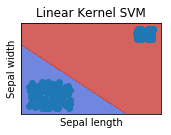

In [33]:
def getColor(status):
    if status == -1:
        return (1.0, 0.0, 0.0)
    else:
        return (0.0, 0.0, 1.0)
    
x1 = np.random.uniform(-5.0, 0., (100, 2))
x1_labeled = np.insert(x1, 2, np.zeros(100, dtype=int) - 1, axis=1)
x2 = np.random.uniform(8.0, 10.0, (100, 2))
x2_labeled = np.insert(x2, 2, np.ones(100, dtype=int), axis=1)
x = np.concatenate([x1_labeled, x2_labeled])
xTrain, xTest, yTrain, yTest = train_test_split(x[:, :2], x[:, -1],
                                               test_size=1/3, random_state=int(time.time()))

learnRate = 1e-3
classifier = MySVM(C=1, learningRate=learnRate, method='primal', maxIter=100)
classifier.fit(xTrain, yTrain)
print('Weights:', classifier.weights)
accuracy, precision, recall, f1 = classifier.score(xTest, yTest)
print('Accuracy: {:.4f}, precision: {:.4f}, recall: {:.4f}, F1: {:.4f}'.format(
        accuracy, precision, recall, f1))

# Plot the decision boundary. For that, we will assign a color to each
# point in the mesh [x_min, x_max]x[y_min, y_max].
h = .02  # step size in the mesh
x_min, x_max = x[:, 0].min() - 1, x[:, 0].max() + 1
y_min, y_max = x[:, 1].min() - 1, x[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                     np.arange(y_min, y_max, h))
plt.subplot(2, 2, 1)
plt.subplots_adjust(wspace=0.4, hspace=0.4)

Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)

# Plot also the training points
plt.scatter(x[:, 0], x[:, 1], cmap=plt.cm.coolwarm)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')
plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())
plt.xticks(())
plt.yticks(())
plt.title('Linear Kernel SVM')
plt.show()